In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pycta.portfolio import Portfolio
from pycta.beakerx import *
from pycta.analysis import Analysis
from pycta.linalg import *
from pycta.signal import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load prices
prices = pd.read_csv("data/prices.csv", index_col=0, parse_dates=True).ffill().truncate(before="1970-01-01")

In [3]:
T = time.time()
correlation = 200

# this is a lot faster than Pandas...
position = np.nan*np.zeros_like(prices.values)

returns_adj = prices.apply(returns_adjust, com=32, clip=4.2)
# DCC by Engle
cor = returns_adj.ewm(com=correlation, min_periods=correlation).corr()

mu = np.tanh(returns_adj.cumsum().apply(osc)).values
vo = prices.pct_change().ewm(com=32, min_periods=32).std().values

for n,t in enumerate(prices.index):
    matrix = shrink2id(cor.loc[t].values, lamb=0.5)
    risk_position = solve(matrix, mu[n])/inv_a_norm(mu[n], matrix)
    position[n] = risk_position/vo[n]

portfolio = Portfolio(prices, pd.DataFrame(index=prices.index, columns=prices.keys(), data=position))
print(time.time()-T)


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


27.904436826705933


In [4]:
a = Analysis(portfolio.nav())
a.performance

Performance number
Annua Return                           24.42
Annua Volatility                       16.03
Annua Sharpe Ratio (r_f = 0)            1.52
Max Drawdown                           32.52
Return                          4,464,376.75
Kurtosis                                1.38
dtype: object

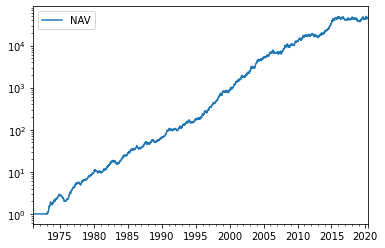

In [5]:
a.nav.plot(logy=True)
plt.show()

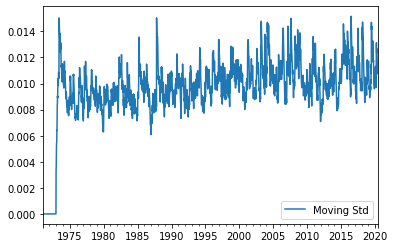

In [6]:
a.std.plot(kind="line")
plt.show()

# Conclusions
* Dramatic relativ improvements observable despite using the same signals as in previous Experiment.
* Main difference here is to take advantage of cross-correlations in the risk measurement.
* Possible to add constraints on individual assets or groups of them.
* Possible to reflect trading costs in objective with regularization terms (Ridge, Lars, Elastic Nets, ...)